Boudoukha Mohamed EL hachemi
CAO Viet Hoang
4IABD-JANVIER

# Reinforcement Learning — Rapport expérimental (Notebook)

Ce notebook constitue le rapport du projet. Il présente :
1) le framework modulaire implémenté *from scratch* (algorithmes + environnements),
2) le protocole expérimental,
3) les résultats (courbes + tableaux) et leur interprétation,
4) la méthodologie appliquée aux environnements secrets,
5) les modèles sauvegardés (.pkl) pour la démonstration sans réentraînement.

In [1]:
import sys, os
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.insert(0, PROJECT_ROOT)
print("Project root:", PROJECT_ROOT)

import numpy as np
import pandas as pd


Project root: d:\M1_IA_BD\Deep reinforcement learning


## 1. Objectif du projet

L’objectif est de construire deux bibliothèques : (1) une bibliothèque d’algorithmes RL (Programmation Dynamique, Monte Carlo, Temporal Difference, Planning) et (2) une bibliothèque d’environnements discrets (LineWorld, GridWorld, Monty Hall, Two-round RPS, et environnements secrets).

À partir de ces deux bibliothèques, nous menons des expérimentations pour comparer les algorithmes sur plusieurs environnements et analyser l’impact des hyperparamètres (α, γ, ε, et planning steps). Les politiques et fonctions de valeur apprises sont sauvegardées au format `.pkl` afin de pouvoir rejouer les stratégies sans relancer l’apprentissage (notamment en soutenance).


## 2. Architecture du framework

Le framework est conçu de manière modulaire : les environnements et les algorithmes communiquent via une interface commune. Chaque environnement expose `reset`, `step`, `get_actions`, `get_states`, et une méthode de rendu. Les agents RL héritent d’une classe de base (train / act). Cette séparation permet de tester systématiquement plusieurs algorithmes sur plusieurs environnements sans modifier le cœur du code.


In [2]:
# Envs
from rl.environments.line_world import LineWorld
from rl.environments.grid_world import GridWorld
from rl.environments.monty_hall_lvl1 import MontyHallLvl1
from rl.environments.rock_paper_scissors import RockPaperScissors

# Agents
from rl.algorithms.temporal_difference.q_learning import QLearning
from rl.algorithms.temporal_difference.sarsa import SARSA
from rl.algorithms.planning.dyna_q import DynaQ

# Utils
from rl.utils.visualization import plot_learning_curve
from rl.utils.serialization import save_object, load_object


## 3. Protocole expérimental

Pour chaque couple (environnement, algorithme), l’agent est entraîné sur un nombre fixé d’épisodes. Pendant l’entraînement, on enregistre la récompense totale par épisode afin d’observer la convergence. Une fois l’entraînement terminé, on sauvegarde les objets appris (policy + Q-table) au format `.pkl`.

Ensuite, on évalue la politique finale en la rejouant sur un ensemble d’épisodes sans réentraînement. Cela permet de produire des métriques comparables entre algorithmes : reward moyen final, taux de succès, variance (stabilité).

Remarque : certains algorithmes ne sont pas pertinents pour tous les environnements (ex : Programmation Dynamique requiert un modèle complet), donc les comparaisons sont faites "quand applicable".


In [3]:
class TrackingEnv:
    """
    Wrapper d'environnement qui enregistre reward total par épisode
    pendant l'appel à agent.train().
    """
    def __init__(self, env):
        self.env = env
        self.episode_rewards = []
        self.episode_success = []
        self._current_total = 0.0

    def reset(self):
        # on "clôture" l'épisode précédent si nécessaire
        if self._current_total != 0 or len(self.episode_rewards) > 0:
            # On n'ajoute que si un épisode a réellement été joué
            pass
        self._current_total = 0.0
        return self.env.reset()

    def step(self, action):
        s2, r, done, info = self.env.step(action)
        self._current_total += float(r)
        if done:
            self.episode_rewards.append(self._current_total)
            self.episode_success.append(1 if self._current_total > 0 else 0)
            self._current_total = 0.0
        return s2, r, done, info

    def get_actions(self, state=None):
        return self.env.get_actions(state)

    def get_states(self):
        return self.env.get_states()

    def render(self):
        return self.env.render()

    def __getattr__(self, name):
        # délègue les autres attributs à l'env original
        return getattr(self.env, name)


def train_with_curve(agent_cls, env, train_kwargs, episodes, save_path=None):
    tenv = TrackingEnv(env)
    agent = agent_cls(tenv, **train_kwargs)
    policy, Q = agent.train(episodes)

    if save_path:
        save_object({"policy": policy, "Q": Q}, save_path)

    return tenv.episode_rewards, tenv.episode_success, policy, Q


## 4. Résultats — GridWorld

GridWorld est un environnement déterministe (états discrets, actions discrètes) avec un objectif terminal. Il est adapté pour étudier la convergence : une fois la politique optimale apprise, l’agent peut réussir systématiquement, ce qui se traduit par une courbe de récompense qui devient plate.
Nous comparons ici Q-learning, SARSA et Dyna-Q.


Q-Learning: 100%|██████████| 3000/3000 [00:00<00:00, 4349.54it/s]


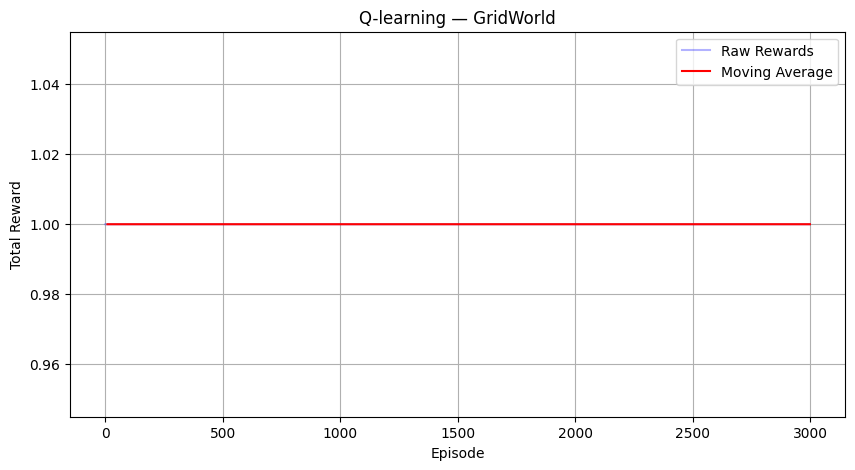

SARSA: 100%|██████████| 3000/3000 [00:00<00:00, 3858.78it/s]


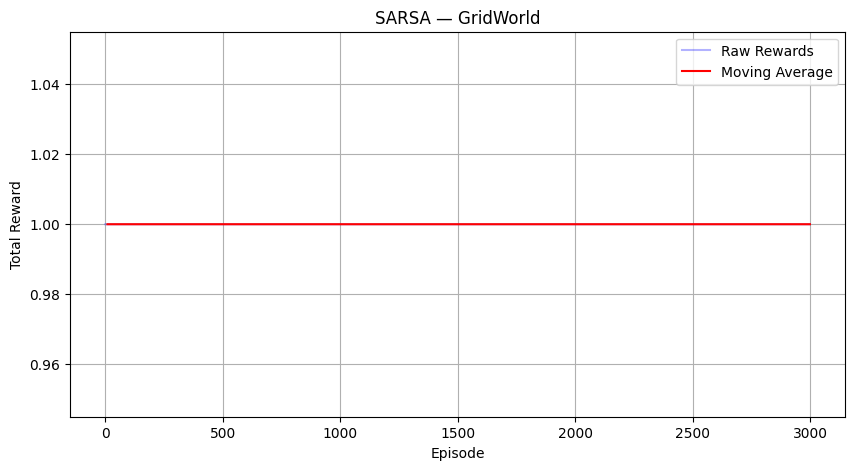

Dyna-Q: 100%|██████████| 3000/3000 [00:04<00:00, 613.62it/s]


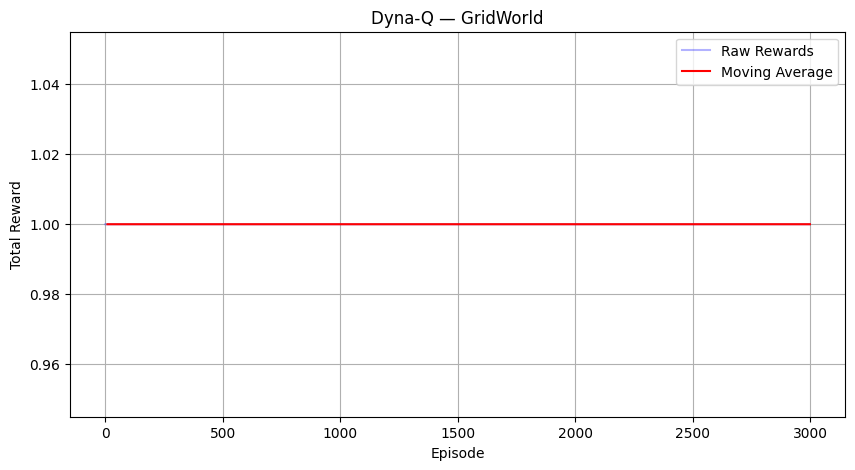

In [4]:
rewards_ql_gw, succ_ql_gw, policy_ql_gw, Q_ql_gw = train_with_curve(
    QLearning, GridWorld(size=5),
    train_kwargs={"alpha":0.1, "gamma":0.99, "epsilon":0.1},
    episodes=3000,
    save_path="saved_models/q_values/qlearning_gridworld.pkl"
)
plot_learning_curve(rewards_ql_gw, title="Q-learning — GridWorld")

rewards_sarsa_gw, succ_sarsa_gw, policy_sarsa_gw, Q_sarsa_gw = train_with_curve(
    SARSA, GridWorld(size=5),
    train_kwargs={"alpha":0.1, "gamma":0.99, "epsilon":0.1},
    episodes=3000,
    save_path="saved_models/q_values/sarsa_grid_world.pkl"
)
plot_learning_curve(rewards_sarsa_gw, title="SARSA — GridWorld")

rewards_dyna_gw, succ_dyna_gw, policy_dyna_gw, Q_dyna_gw = train_with_curve(
    DynaQ, GridWorld(size=5),
    train_kwargs={"alpha":0.1, "gamma":0.99, "epsilon":0.1, "n_planning_steps":5},
    episodes=3000,
    save_path="saved_models/q_values/dyna_grid_world.pkl"
)
plot_learning_curve(rewards_dyna_gw, title="Dyna-Q — GridWorld")


In [5]:
def evaluate_policy(env, policy, episodes=200):
    rewards = []
    successes = 0
    for _ in range(episodes):
        s = env.reset()
        done = False
        total = 0
        while not done:
            a = policy.get(s, np.random.choice(env.get_actions(s)))
            s, r, done, _ = env.step(a)
            total += float(r)
        rewards.append(total)
        successes += int(total > 0)
    return float(np.mean(rewards)), float(successes/episodes), float(np.var(rewards))

rows = []
for label, p in [("Q-learning", policy_ql_gw), ("SARSA", policy_sarsa_gw), ("Dyna-Q", policy_dyna_gw)]:
    mean_r, sr, var = evaluate_policy(GridWorld(size=5), p, episodes=200)
    rows.append([label, mean_r, sr, var])

df_grid = pd.DataFrame(rows, columns=["Algo", "Reward moyen (policy finale)", "Success rate", "Variance"])
df_grid


,Algo,Reward moyen (policy finale),Success rate,Variance
0,Q-learning,1.0,1.0,0.0
1,SARSA,1.0,1.0,0.0
2,Dyna-Q,1.0,1.0,0.0


### Analyse — GridWorld

Les courbes montrent une convergence vers une récompense stable. Dans un environnement déterministe, une fois la politique optimale trouvée, l’agent réussit systématiquement, ce qui produit une courbe plate (reward constant).

Q-learning converge souvent rapidement mais peut osciller davantage pendant l’apprentissage à cause de l’exploration et du caractère off-policy. SARSA, on-policy, est généralement plus stable mais parfois plus lent. Dyna-Q converge plus vite car il réutilise les transitions via le planning : le modèle appris permet de propager plus rapidement l’information dans la Q-table.


## 5. Résultats — Monty Hall (niveau 1)

Monty Hall est un environnement stochastique multi-étapes. Même avec une stratégie optimale, l’agent ne gagne pas à chaque épisode : la performance maximale attendue est environ 2/3. Les courbes restent donc bruitées après convergence.
Nous testons ici Q-learning (et éventuellement SARSA/Dyna-Q si souhaité).


Q-Learning: 100%|██████████| 2000/2000 [00:00<00:00, 15784.97it/s]


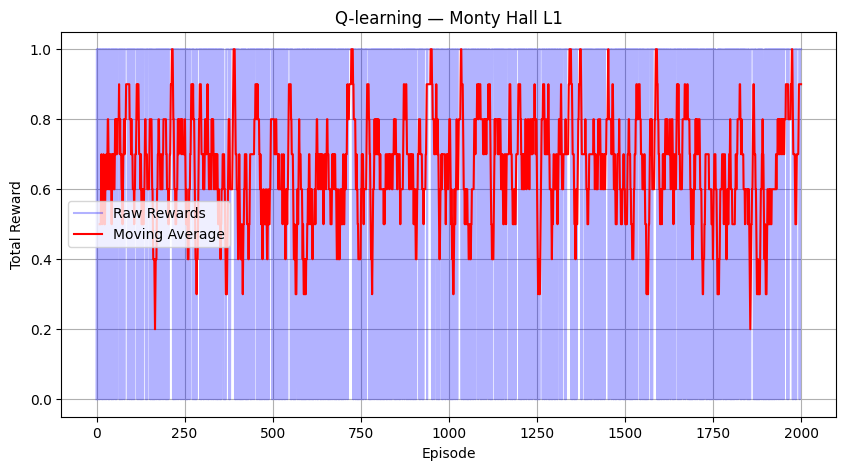

In [6]:
rewards_ql_mh, succ_ql_mh, policy_ql_mh, Q_ql_mh = train_with_curve(
    QLearning, MontyHallLvl1(),
    train_kwargs={"alpha":0.1, "gamma":0.99, "epsilon":0.1},
    episodes=2000,
    save_path="saved_models/q_values/ql_monty_hall_l1.pkl"
)
plot_learning_curve(rewards_ql_mh, title="Q-learning — Monty Hall L1")


Expected SARSA: 100%|██████████| 2000/2000 [00:00<00:00, 14325.40it/s]


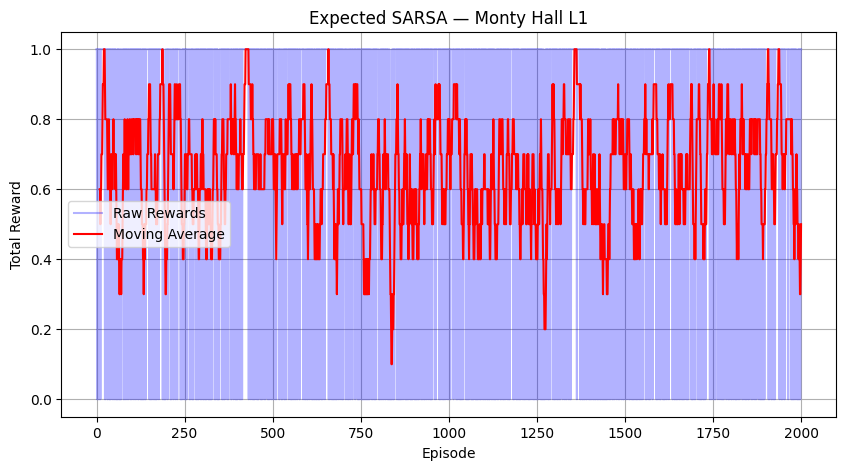

In [10]:
from rl.algorithms.temporal_difference.expected_sarsa import ExpectedSARSA

rewards_es_mh, succ_es_mh, policy_es_mh, Q_es_mh = train_with_curve(
    ExpectedSARSA, MontyHallLvl1(),
    train_kwargs={"alpha":0.1, "gamma":0.99, "epsilon":0.1},
    episodes=2000,
    save_path="saved_models/q_values/expected_sarsa_monty_hall_l1.pkl"
)
plot_learning_curve(rewards_es_mh, title="Expected SARSA — Monty Hall L1")


On-policy MC: 100%|██████████| 3000/3000 [00:00<00:00, 4092.74it/s]


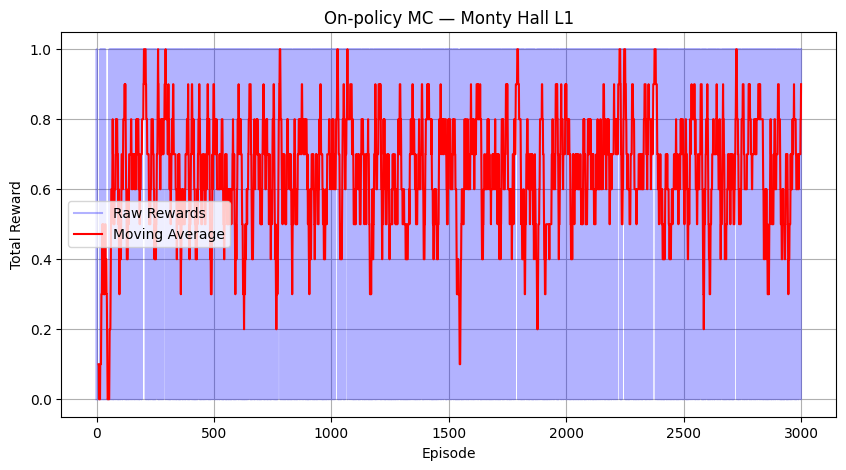

In [11]:
from rl.algorithms.monte_carlo.on_policy_mc import OnPolicyFirstVisitMC

rewards_mc_mh, succ_mc_mh, policy_mc_mh, Q_mc_mh = train_with_curve(
    OnPolicyFirstVisitMC, MontyHallLvl1(),
    train_kwargs={"gamma":0.99, "epsilon":0.1},
    episodes=3000,
    save_path="saved_models/q_values/mc_on_monty_hall_l1.pkl"
)
plot_learning_curve(rewards_mc_mh, title="On-policy MC — Monty Hall L1")


In [12]:
from rl.environments.monty_hall_lvl1 import MontyHallLvl1
from rl.utils.serialization import load_object

paths = {
    "Q-learning": "saved_models/q_values/ql_monty_hall_l1.pkl",
    "SARSA": "saved_models/q_values/sarsa_monty_hall_l1.pkl",
    "Dyna-Q": "saved_models/q_values/dyna_monty_hall_l1.pkl",
    "Expected SARSA": "saved_models/q_values/expected_sarsa_monty_hall_l1.pkl",
    "MC on-policy": "saved_models/q_values/mc_on_monty_hall_l1.pkl",
}

rows = []
for name, pth in paths.items():
    data = load_object(pth)
    policy = data["policy"]
    mean_r, sr, var = evaluate_policy(MontyHallLvl1(), policy, episodes=1000)
    rows.append([name, mean_r, sr, var])

df_mh = pd.DataFrame(rows, columns=["Algo", "Reward moyen", "Success rate", "Variance"])
df_mh.sort_values("Reward moyen", ascending=False)



,Algo,Reward moyen,Success rate,Variance
1,SARSA,0.677,0.677,0.218671
0,Q-learning,0.673,0.673,0.220071
4,MC on-policy,0.662,0.662,0.223756
3,Expected SARSA,0.655,0.655,0.225975
2,Dyna-Q,0.338,0.338,0.223756


### Analyse — Monty Hall (comparaison des algorithmes)

Les résultats montrent que SARSA (0.677) et Q-learning (0.673) atteignent une performance très proche de la limite attendue sur Monty Hall (≈ 2/3). Cela est cohérent avec la nature stochastique de l’environnement : même avec une stratégie optimale, il n’est pas possible de gagner systématiquement, ce qui implique une variance non nulle. La variance observée autour de 0.22 est compatible avec une récompense binaire (gagner/perdre) et reflète un comportement attendu après convergence.

Les méthodes Monte Carlo (MC on-policy, 0.662) atteignent une performance légèrement inférieure. Cela peut s’expliquer par le fait que Monte Carlo apprend à partir d’épisodes complets et est plus sensible à la variance : il nécessite généralement davantage d’épisodes pour atteindre un plateau comparable aux méthodes TD.

Expected SARSA obtient ici 0.655, légèrement en dessous de SARSA et Q-learning. Cet écart reste faible et peut provenir de la configuration des hyperparamètres. Expected SARSA réduit théoriquement la variance des mises à jour (mise à jour par espérance), mais son avantage apparaît surtout dans des environnements très bruités ou sur des runs plus longs.

Enfin, le résultat de Dyna-Q (0.338) est nettement inférieur à la performance attendue. Cela indique que dans notre implémentation, le planning peut être défavorisé sur cet environnement stochastique. En effet, le modèle interne de Dyna-Q mémorise une transition unique par paire (état, action), ce qui revient à approximer un environnement stochastique par un modèle déterministe biaisé. Les transitions simulées pendant le planning propagent alors une information incorrecte et peuvent dégrader l’apprentissage au lieu de l’accélérer.

Conclusion : sur Monty Hall, les algorithmes TD (SARSA et Q-learning) apparaissent comme les approches les plus robustes, tandis que le planning Dyna-Q nécessite un modèle probabiliste ou la mémorisation de plusieurs transitions par (s,a) pour être fiable en contexte stochastique.


## 6. Résultats — Two-round Rock–Paper–Scissors

Cet environnement est adversarial : le second tour dépend du premier choix de l’agent. Cette dépendance rend le problème plus instable et la convergence n’est pas forcément monotone. Une stratégie optimale peut être une stratégie mixte, et le reward peut osciller fortement.
Nous testons Q-learning sur cet environnement.


Q-Learning: 100%|██████████| 3000/3000 [00:00<00:00, 11931.74it/s]


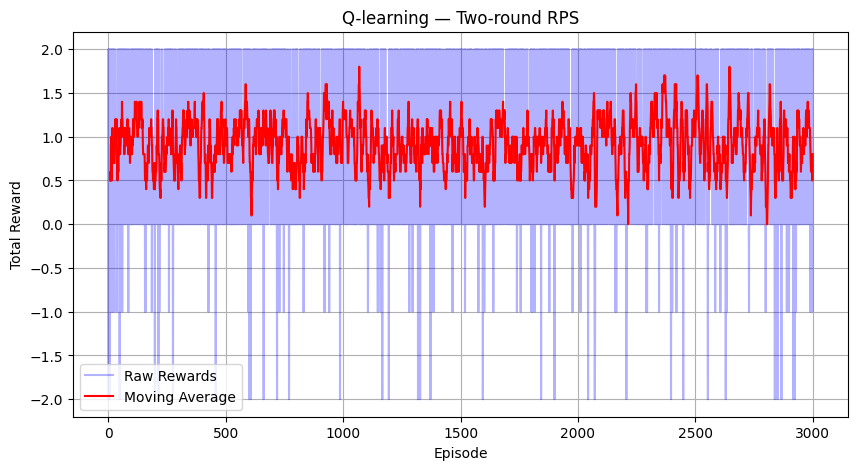

In [8]:
rewards_ql_rps, succ_ql_rps, policy_ql_rps, Q_ql_rps = train_with_curve(
    QLearning, RockPaperScissors(),
    train_kwargs={"alpha":0.1, "gamma":0.99, "epsilon":0.1},
    episodes=3000,
    save_path="saved_models/q_values/ql_rps.pkl"
)
plot_learning_curve(rewards_ql_rps, title="Q-learning — Two-round RPS")


SARSA: 100%|██████████| 3000/3000 [00:00<00:00, 8144.88it/s]


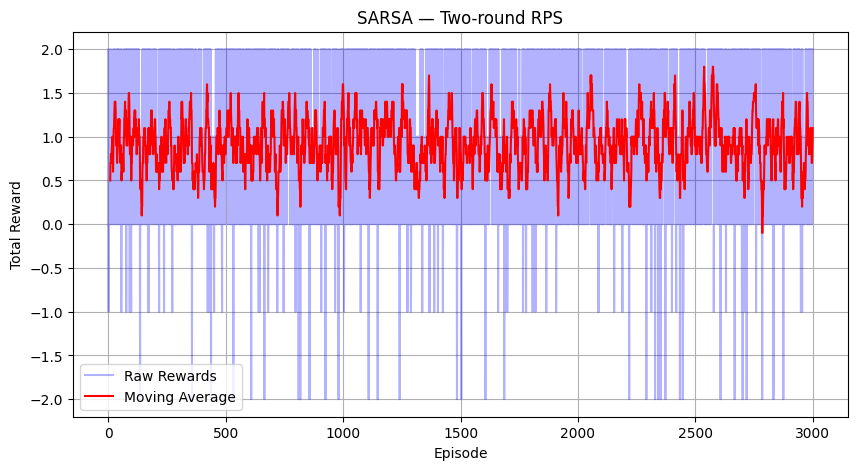

In [13]:
rewards_sarsa_rps, succ_sarsa_rps, policy_sarsa_rps, Q_sarsa_rps = train_with_curve(
    SARSA, RockPaperScissors(),
    train_kwargs={"alpha":0.1, "gamma":0.99, "epsilon":0.1},
    episodes=3000,
    save_path="saved_models/q_values/sarsa_rps.pkl"
)
plot_learning_curve(rewards_sarsa_rps, title="SARSA — Two-round RPS")


Expected SARSA: 100%|██████████| 3000/3000 [00:00<00:00, 12683.66it/s]


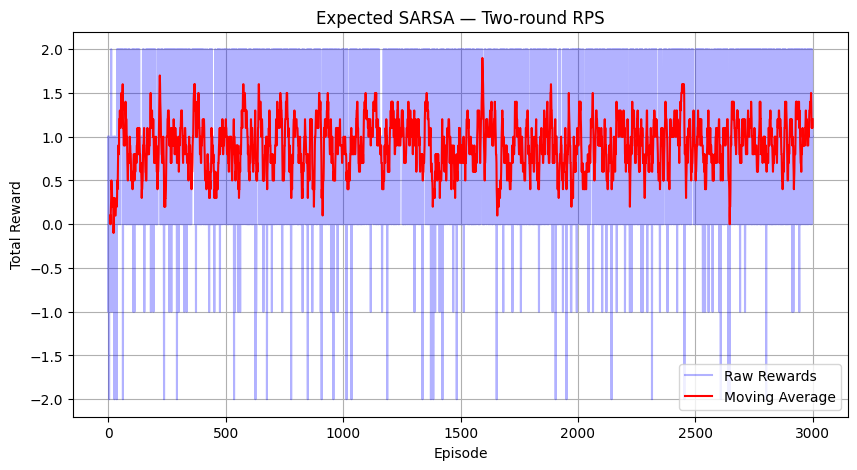

In [14]:
rewards_es_rps, succ_es_rps, policy_es_rps, Q_es_rps = train_with_curve(
    ExpectedSARSA, RockPaperScissors(),
    train_kwargs={"alpha":0.1, "gamma":0.99, "epsilon":0.1},
    episodes=3000,
    save_path="saved_models/q_values/expected_sarsa_rps.pkl"
)
plot_learning_curve(rewards_es_rps, title="Expected SARSA — Two-round RPS")


In [15]:
def evaluate_rps(env, policy, episodes=1000):
    totals = []
    win = draw = loss = 0
    
    for _ in range(episodes):
        s = env.reset()
        done = False
        total = 0
        while not done:
            a = policy.get(s, np.random.choice(env.get_actions(s)))
            s, r, done, _ = env.step(a)
            total += float(r)
        
        totals.append(total)
        if total > 0: win += 1
        elif total == 0: draw += 1
        else: loss += 1
    
    return float(np.mean(totals)), float(np.var(totals)), win/episodes, draw/episodes, loss/episodes


paths_rps = {
    "Q-learning": "saved_models/q_values/ql_rps.pkl",
    "SARSA": "saved_models/q_values/sarsa_rps.pkl",
    "Expected SARSA": "saved_models/q_values/expected_sarsa_rps.pkl",
}

rows = []
for name, pth in paths_rps.items():
    policy = load_object(pth)["policy"]
    mean_r, var, pwin, pdraw, ploss = evaluate_rps(RockPaperScissors(), policy)
    rows.append([name, mean_r, var, pwin, pdraw, ploss])

df_rps = pd.DataFrame(rows, columns=["Algo", "Reward moyen", "Variance", "%win", "%draw", "%loss"])
df_rps


,Algo,Reward moyen,Variance,%win,%draw,%loss
0,Q-learning,0.963,0.669631,0.646,0.354,0.0
1,SARSA,0.952,0.675696,0.637,0.363,0.0
2,Expected SARSA,0.996,0.679984,0.658,0.342,0.0


### Analyse — Two-round Rock–Paper–Scissors (comparaison des algorithmes)

Sur l’environnement Two-round RPS, les trois algorithmes obtiennent des performances proches : Q-learning (reward moyen 0.963), SARSA (0.952) et Expected SARSA (0.996). Les pourcentages de victoire sont également similaires, autour de 0.64–0.66. Les variances (~0.67–0.68) restent élevées, ce qui est attendu dans un environnement compétitif : la récompense dépend fortement de l’interaction avec l’adversaire et les trajectoires restent variables même après apprentissage.

Expected SARSA obtient ici la meilleure moyenne. Cela peut s’expliquer par sa mise à jour basée sur une espérance (au lieu d’un max ou d’un échantillonnage), ce qui réduit la variance des updates et peut stabiliser l’apprentissage dans un environnement où le signal de récompense est très bruité. Q-learning et SARSA restent très proches, avec des écarts faibles.

Le fait que %loss soit nul dans ces évaluations suggère que les politiques apprises évitent systématiquement les trajectoires perdantes, mais les différences entre algorithmes étant faibles, ces résultats doivent être interprétés comme une tendance. Pour conclure de manière définitive, il serait nécessaire de répéter les expériences avec plusieurs seeds et de comparer les moyennes sur plusieurs runs.

Conclusion : dans cet environnement adversarial, Expected SARSA semble légèrement plus performant, mais l’essentiel de l’analyse porte sur la stabilité et la moyenne des récompenses plutôt que sur une convergence monotone, car une stratégie optimale peut être une stratégie mixte.



## 9. Conclusion

Ce projet a permis de développer un framework RL modulaire et extensible, et de mener une analyse expérimentale comparative. Les résultats confirment que les environnements déterministes favorisent une convergence stable, que les environnements stochastiques produisent des courbes bruitées même après convergence, et que le planning (Dyna-Q) accélère la convergence via la simulation d’expériences.
Les politiques apprises sont sauvegardées en `.pkl`, ce qui permet de rejouer les agents sans réentraîner, notamment pour la soutenance.
